# Качаем файл

In [2]:
import math

import requests

In [12]:
fname_dat = 'checkins.dat'
fname = 'checkins.csv'

In [ ]:
URL = "https://archive.org/download/201309_foursquare_dataset_umn/fsq.zip/umn_foursquare_datasets%2Fcheckins.dat"
r = requests.get(URL, stream=True)
r.content

> Качалось архидолго, поэтому качнули с торрентом

# Конвертируем .dat в .csv

In [6]:
import csv

In [8]:
with open(fname_dat) as dat_file, open(fname, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    for line in dat_file:
        row = [field.strip() for field in line.split('|')]
        if len(row) == 6 and row[3] and row[4]:
            csv_writer.writerow(row)

> фууух нормально сработали можно и отдохнуть

# Читаем файл .csv в DataFrame

In [9]:
import pandas as pd

In [20]:
df = pd.read_csv(fname, )
df

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824,5222,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652,5222,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054,5222,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539,5222,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870,380645,33.448377,-112.074037,2012-04-21 17:38:18
...,...,...,...,...,...,...
396629,955561,626076,20073,40.850100,-73.866246,2012-04-13 09:56:48
396630,955892,674797,2297,33.748995,-84.387982,2012-04-13 10:56:03
396631,956377,845102,11195,42.765366,-71.467566,2012-04-13 12:08:45
396632,956119,1139114,29488,42.439479,-83.743830,2012-04-13 11:36:44


In [14]:
len(df)

396634

> количество строк == 396634 как и нужно

# Готовим данные

In [21]:
lat = df['latitude'].loc[:]
long = df['longitude'].loc[:]
lat[:5], long[:5]

(0    38.895112
 1    33.800745
 2    45.523452
 3    40.764462
 4    33.448377
 Name: latitude, dtype: float64,
 0    -77.036366
 1    -84.410520
 2   -122.676207
 3   -111.904565
 4   -112.074037
 Name: longitude, dtype: float64)

In [25]:
size = 100000  # len(lat) -- ждать час долго((
data = []
for i in range(size):
    data.append([lat[i], long[i]])
data[:5]

[[38.895111799999995, -77.0363658],
 [33.800745, -84.41051999999999],
 [45.5234515, -122.6762071],
 [40.764462, -111.90456499999999],
 [33.4483771, -112.07403729999999]]

# Отрисуем координаты

In [27]:
import matplotlib.pyplot as plt

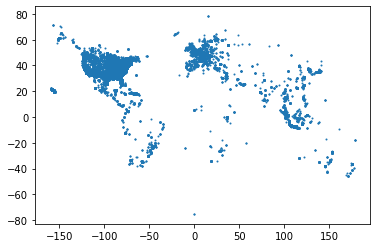

In [29]:
plt.scatter(long, lat, s=1)

> красивое

# Разбираемся с MeanShift

> да кто такой этот ваш миншифт

In [15]:
from sklearn.cluster import MeanShift

In [16]:
ms = MeanShift(bandwidth=0.1)

In [26]:
ms.fit(data)

MeanShift(bandwidth=0.1)

In [34]:
centers = ms.cluster_centers_
print(f'Количество кластеров = {len(centers)}')

Количество кластеров = 3231


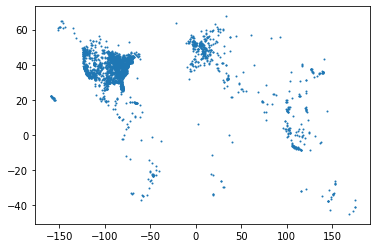

In [33]:
plt.scatter([i[1] for i in centers], [i[0] for i in centers], s=1)

# Отфильтруем кластеры

In [99]:
ms.cluster_centers_

array([[  40.7177164 ,  -73.99183542],
       [  33.44943805, -112.00213969],
       [  33.44638027, -111.90188756],
       ...,
       [ -37.8229826 ,  145.1811902 ],
       [ -41.2924945 ,  174.7732353 ],
       [ -45.0311622 ,  168.6626435 ]])

In [ ]:
clusters = dict()
for i, label in enumerate(ms.labels_):
    if label not in clusters.keys():
        clusters[label] = {(data[i][0], data[i][1])}
    else:
        clusters[label].add((data[i][0], data[i][1]))
len(clusters.keys()) == len(ms.cluster_centers_), len(clusters.keys())

In [103]:
THRESHOLD = 15
data_to_pd_clusters_length = []
clusters_keys_list = sorted(list(clusters.keys()))

for i, _ in enumerate(clusters_keys_list):
    key = clusters_keys_list[i]

    data_to_pd_clusters_length.append(
        [key, len(clusters[key]), tuple(clusters[key]),
         centers[key][0], centers[key][1]])
clusters_df = pd.DataFrame(data_to_pd_clusters_length,
                           columns=['label', 'length', 'coords', 'center_longitude', 'center_latitude'])
useful_clusters = clusters_df.loc[clusters_df['length'] > THRESHOLD].reset_index(drop=True)
useful_clusters

,label,length,coords,center_latitude,center_longitude
0,0,54,"((40.7064461, -73.9536163), (40.6805029, -73.9...",40.717716,-73.991835
1,5,24,"((38.904151, -77.033172), (38.8514028, -77.050...",38.886165,-77.048783
2,8,31,"((42.408430200000005, -71.0119948), (42.28582,...",42.363219,-71.073688
3,14,41,"((40.7108476, -73.8977693), (40.7620463, -73.7...",40.766876,-73.833353
4,24,18,"((34.101418, -118.33659499999999), (34.1489719...",34.127402,-118.351884
5,42,18,"((33.884736100000005, -118.41090890000001), (3...",33.872986,-118.362091
6,48,29,"((40.8120447, -74.12430959999999), (40.833989,...",40.766668,-74.192496
7,52,23,"((40.847322600000005, -73.7865218), (40.897599...",40.870148,-73.859389
8,58,20,"((51.489112, -0.1106702), (51.4929163, -0.2257...",51.502991,-0.125537
9,61,42,"((40.735101799999995, -73.68790820000001), (40...",40.708071,-73.584400


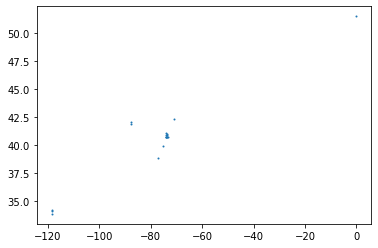

In [105]:
plt.scatter(useful_clusters['center_longitude'], useful_clusters['center_latitude'], s=1)

# Находим ближайшие к офисам

In [106]:
offices = [[34.2720355, -118.4693734], [33.7507188, -118.1889072], [27.9450524, -82.4455656],
           [39.2650447, -76.6007999], [32.717609, -117.1761962], [37.804883, -122.4016302],
           [49.2514431, -123.1277804], [32.7859233, -79.9333731], [30.6860768, -88.0394999],
           [26.1216934, -80.1388889], [33.3882696, -111.6913768], [26.0853385, -80.1180988],
           [30.0068944, -90.1633797], [29.3075638, -94.7986193], [28.4157244, -80.6310168],
           [52.3787031, 4.8849274], [47.3831508, 8.4987319], [41.3905199, 2.1570719],
           [50.4356475, 30.5142909], [53.4699633, -2.2947828]]

In [115]:
import math
distance = lambda coord1, coord2: math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

In [131]:
distances_dict = dict()
for office in offices:
    for clusters_coords in useful_clusters['coords']:
        for coord in clusters_coords:
            dist = distance(office, (coord[1], coord[0]))
            if dist not in distances_dict.keys():
                distances_dict[dist] = [coord]
            else:
                distances_dict[dist].append(coord)
distances_dict

{192.48307255712493: [(40.7064461, -73.9536163)],
 192.46657692400026: [(40.6805029, -73.96243270000001)],
 192.5649695132654: [(40.809033299999996, -73.94837220000001)],
 192.49143055232756: [(40.7245448, -73.9418603)],
 192.52427786202352: [(40.77194, -73.93056)],
 192.5538427005699: [(40.739932, -74.030224)],
 192.54232325881273: [(40.719418, -74.039898)],
 192.45088444618204: [(40.700102799999996, -73.9056922)],
 192.59522266467167: [(40.827044799999996, -73.97569399999999)],
 192.64579764186834: [(40.857044200000004, -74.0215285)],
 192.58204836408504: [(40.7920454, -74.0037505)],
 192.55384484287902: [(40.7834345, -73.9662495)],
 192.54343041470665: [(40.762893638010205, -73.9779424667358)],
 192.5440840443083: [(40.7638003, -73.97777140000001)],
 192.57078281504872: [(40.7281575, -74.0776417)],
 192.62501774951713: [(40.848155600000005, -73.997639)],
 192.6652277647497: [(40.8625996, -74.0479182)],
 192.5845378538425: [(40.787878799999994, -74.0143064)],
 192.65390821868712: [(4

In [132]:
min_distances = sorted(list(distances_dict.keys()))[:20]
min_distances

[54.634760155304356,
 54.640504151674676,
 54.656288431232184,
 54.69617484697593,
 54.70717025375446,
 54.71077611998651,
 54.725436071413256,
 54.73663159567198,
 54.74404502947794,
 54.74873690150091,
 54.76413098286318,
 54.771216391394276,
 54.77404281527019,
 54.78882870446247,
 54.79509378860363,
 54.79599067723418,
 54.80316377127451,
 54.804433365788555,
 54.81132294302883,
 54.833239329411626]

In [133]:
min_coords = []
for min_dist in min_distances:
    min_coords.append(distances_dict[min_dist][0] if len(distances_dict[min_dist]) == 1 else distances_dict[min_dist])
min_coords

[(51.487198, -0.013279),
 (51.508782000000004, -0.0105222),
 (51.5584299, -0.0069345),
 (51.5457865, -0.0554184),
 (51.54139, -0.06916),
 (51.360124, -0.148147),
 (51.489112, -0.1106702),
 (51.534979799999995, -0.1037379),
 (51.5001524, -0.12623620000000002),
 (51.508129, -0.128005),
 (51.5151238, -0.141769),
 (51.539536, -0.139299),
 (51.539187, -0.142505),
 (51.45678970000001, -0.1926795),
 (51.515958399999995, -0.17494690000000002),
 (51.51658, -0.17565999999999998),
 (51.4799393, -0.19861310000000001),
 (51.5018856, -0.19089479999999998),
 (51.505359000000006, -0.196913),
 (51.4929163, -0.2257916)]

In [134]:
MINIMAL_COORD = min_coords[0]
print(f'Ближайшая к офису координата: {MINIMAL_COORD}')

Ближайшая к офису координата: (51.487198, -0.013279)
